In [1]:
%matplotlib inline

In [13]:
from Bio import Entrez, Medline
# from bs4 import BeautifulSoup
# import requests
import pandas as pd
# import time
# import random
# import re

# from matplotlib import pyplot as plt

# First, programattically access NCBI's `pubmed` to perform an *agnostic* affiliation-based search

In [2]:
Entrez.email = 'adam.hockenberry@tempus.com'

In [3]:
search_term = 'tempus'

###Competitors?
# search_term = 'foundation medicine'
# search_term = 'sensyne'
# search_term = 'guardant'
# search_term = 'flatiron'
# search_term = 'caris'

# Get a (sloppy) starting set of PMID's that contain the search term in the affiliation field

In [4]:
##Just looking at hits in different ncbi databases and getting the pubmed count
max_rec = 0
handle = Entrez.egquery(term='{}[ad]'.format(search_term))
record = Entrez.read(handle)
for row in record['eGQueryResult']:
    if row['DbName'] == 'pubmed':
        max_rec = int(row['Count'])

In [5]:
###Gather the PMIDs
handle = Entrez.esearch(db='pubmed', term='{}[ad]'.format(search_term), retmax=max_rec)
record = Entrez.read(handle)
handle.close()
id_list = record['IdList']
assert len(id_list) == max_rec 

###Then do a fetch to return the text data for each record
handle = Entrez.efetch(db="pubmed", id=id_list, rettype="medline",
                        retmode="text")
records = list(Medline.parse(handle))
assert len(records) == max_rec

# Fix/check the affiliation errors

In [6]:
###Read in a file that contains terms to remove / not count
try:
    with open('../../Data/{}_removal.txt'.format(''.join(search_term)), 'r') as infile:
        pre_removed = infile.read().splitlines()
        print('Found {} existing affiliation strings to remove from consideration:'.format(len(pre_removed)))
except FileNotFoundError:
    print('Did not find any previous file so starting afresh')
    pre_removed = []
print()
for line in pre_removed:
    print(line)

Found 0 existing affiliation strings to remove from consideration:



In [7]:
possible_names = []
for record in records:
    affil_of_interest = 0
    for affil in record['AD']:
        if search_term in affil.lower():
            tempy = affil.lower()
            for error in pre_removed:
                tempy = tempy.replace(error, '***')
            if search_term in tempy:            
                possible_names.append(affil)
print('Affiliations that remain and will be considered valid:')
print()
for i in set(possible_names):
    print(i)

Affiliations that remain and will be considered valid:

Tempus, Chicago, IL, USA.
Tempus Labs, Inc., Chicago, IL, 60654, USA. kevin@tempus.com.
Tempus Labs, Chicago, IL. Electronic address: publications@Tempus.com.
Tempus Labs Inc, Chicago, IL (A.N., T.C., K.W.J., N.Z., A.H.).
Tempus Labs, Chicago, IL, USA. Nike.Beaubier@tempus.com.
Tempus Software, Inc., Jacksonville, FL, USA.
Tempus Labs, Chicago, USA. kevin@tempus.com.
Department of Surgery, The University of Chicago Medicine, Chicago, Illinois. kpwhite@uchicago.edu kevin@tempus.com.
Tempus, Inc., Chicago, IL, USA.
Tempus Labs, Chicago, IL, 60654, USA. kpwhite@uchicago.edu.
Tempus Labs, Chicago, IL, USA. bob@tempus.com.
Tempus Labs Inc, Chicago, IL.
Faculty of Metallurgy and Materials Science, University of Mining and Metallurgy, 30 Mickiewicza Ave., 30-059 Krakow, Poland. skac@tempus.metal.agh.edu.pl
Tempus Labs, Inc., Chicago, IL, USA. kevin@tempus.com.
Tempus Labs, Chicago, IL 60654, USA; Department of Pathology, Biological Scien

**Strange entries (should these be removed?):**

Medical Informatics Tempus and Kanter Health Foundation Chicago Illinois.

Tempus Health, Incorporated, Chicago, Illinois 60654, USA.

Google Health, Tempus Labs Inc., Chicago, IL, USA.

Tempus, Redwood City, California.

Tempus Labs, Boston, MA, USA.

In [8]:
to_remove = []
new_to_remove = pre_removed + to_remove
with open('../../Data/{}_removal.txt'.format(''.join(search_term)), 'w') as outfile:
    for i in new_to_remove:
        outfile.write(i+'\n')

# Pare down the records based on whether they contain a valid affiliation

In [9]:
valid_ids = []
for record in records:
    affil_of_interest = 0
    for affil in record['AD']:
        if search_term in affil.lower():
            tempy = affil.lower()
            for error in new_to_remove:
                tempy = tempy.replace(error, '***')
            if search_term in tempy:
                affil_of_interest +=1
    if affil_of_interest > 0:
        valid_ids.append(record['PMID'])
print(len(records), len(valid_ids))

127 127


# Move forward with this set of validated publications

**First fetch `xml` information on each**

In [10]:
handle = Entrez.efetch(db="pubmed", id=valid_ids, rettype="medline",
                        retmode="xml")
records = Entrez.read(handle)

**Extract basic / relevant information from pubmed**

In [11]:
pmids = []
titles = []
dois = []
journals = []
years_journal = []
volumes = []
issues = []
n_authors = []
n_affil_authors = []
affil_author_names = []
for record in records['PubmedArticle']:
    pmids.append(int(record['MedlineCitation']['PMID']))
    titles.append(record['MedlineCitation']['Article'].get('ArticleTitle'))
    journals.append(record['MedlineCitation']['Article']['Journal'].get('Title', ''))
    years_journal.append(record['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate'].get('Year', ''))
    volumes.append(record['MedlineCitation']['Article']['Journal']['JournalIssue'].get('Volume', ''))
    issues.append(record['MedlineCitation']['Article']['Journal']['JournalIssue'].get('Issue', ''))
    ###DOI is a bit more complicated
    doi = ''
    for item in record['MedlineCitation']['Article']['ELocationID']:
        if item.attributes['EIdType']=='doi':
            doi = str(item)
    dois.append(doi)
    ###Authorship gets really complicated
    total_authors = 0
    affil_authors = 0
    affil_author_list = []
    for person in record['MedlineCitation']['Article']['AuthorList']:
        affil_author = False
        ln = person.get('LastName', '')
        if ln == '':
            continue
        total_authors += 1
        name = (person['LastName']+' '+person['ForeName']).replace(' ', '_')
        affiliations = person['AffiliationInfo']
        for affiliation in affiliations:
            if affiliation['Affiliation'] in possible_names:
                affil_author=True
        if affil_author:
            affil_authors += 1
            affil_author_list.append(name)
    ###Finally adding
    n_authors.append(total_authors)
    n_affil_authors.append(affil_authors)
    affil_author_names.append('; '.join(affil_author_list))

In [14]:
pubs_df = pd.DataFrame(zip(pmids, titles, dois, journals, years_journal, volumes, issues,
                           n_authors, n_affil_authors, affil_author_names),\
                       columns = ['PMID', 'Title', 'DOI', 'Journal', 'Year', 'Volume', 'Issue',\
                                  'Total_author_count', 'Affiliated_author_count', 'Affiliated_author_names'])
print(pubs_df.shape)
pubs_df.head()

(127, 10)


,PMID,Title,DOI,Journal,Year,Volume,Issue,Total_author_count,Affiliated_author_count,Affiliated_author_names
0,35339649,Phase 2 single arm study of nivolumab and ipil...,10.1016/j.annonc.2022.03.012,Annals of oncology : official journal of the E...,2022,,,19,1,Schwarzbach_A_E
1,35319967,"Landscape of <i>KRAS</i><sup>G12C</sup>, Assoc...",10.1200/PO.21.00245,JCO precision oncology,2022,6,,15,3,El-Refai_Sherif_M; O'Neil_Bert; Barrett_Alexan...
2,35274707,"Homologous Recombination Deficiency: Concepts,...",10.1093/oncolo/oyab053,The oncologist,2022,27,3,25,2,Beaubier_Nike; Parsons_Jerod
3,35263765,Researching Compassionate Communities from an ...,10.1093/geront/gnac034,The Gerontologist,2022,,,15,2,Van_Droogenbroeck_Filip; Spruyt_Bram
4,35233056,Crizotinib in patients with tumors harboring A...,10.1038/s41698-022-00256-w,NPJ precision oncology,2022,6,1,29,1,Malik_N


# Other possible things to look out for / drop

**Can stack on keywords in the "title" field to ignore using the pattern below**

In [14]:
print(pubs_df.shape)
for bad_title in ['author correction', 'correction to:']:
    pubs_df = pubs_df[pubs_df['Title'].str.contains(bad_title, case=False) == False]
    print(pubs_df.shape)

(99, 10)
(94, 10)
(93, 10)


**Can similarly remove particular journals**

In [15]:
print(pubs_df.shape)
for bad_journal in ['arxiv', 'biorxiv', 'medrxiv']:
    pubs_df = pubs_df[pubs_df['Journal'].str.contains(bad_journal, case=False) == False]
    print(pubs_df.shape)

(93, 10)
(93, 10)
(93, 10)
(91, 10)


**Drop mistakes / errors via a process of MANUAL curation**

In [16]:
pmids_to_drop = []

**^^^STILL NEED TO WRITE THIS, CHECK IN WITH AB**

# Finally, write results to a file

In [17]:
pubs_df = pubs_df.sort_values('Year', ascending=False)

In [18]:
pubs_df = pubs_df.sort_values('Year', ascending=False)
pubs_df.to_csv('../Results/{}.tsv'.format('_'.join(search_term.split(' '))), index=False, sep='\t')

# Plots!

In [22]:
pubs_df.shape

(91, 10)

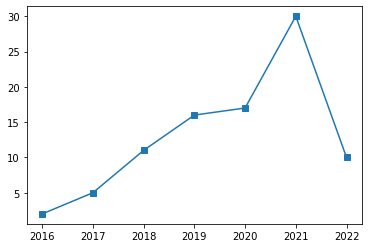

In [24]:
years = [2016, 2017, 2018, 2019, 2020, 2021, 2022]
y_vals = []
temp_dict = dict(pubs_df[pubs_df['Affiliated_author_count']>=1]['Year'].value_counts())
for year in years:
    y_vals.append(temp_dict.get(str(year), 0))
    
fig, ax = plt.subplots()
ax.plot(years, y_vals, marker='s')

# Scratch

# Add in citation data via google scholar

Note that there are some different ways to do this using Pubmed for instance. Unfortunatley, pubmed appears to only track PMC articles which are a small subset of all publications. See:

```
pmid = xyzpqr
results = Entrez.read(Entrez.elink(dbfrom="pubmed", db="pubmed", LinkName="pubmed_pmc_refs", id=pmid))
pmc_ids = [link["Id"] for link in results[0]["LinkSetDb"][0]["Link"]]
pmc_ids
```

In [ ]:
# citation_count = []
# with requests.Session() as s:
#     for index in pubs_df.index:
#         if pubs_df.at[index, 'DOI'] != '':
#             query = pubs_df.at[index, 'DOI']
#         else:
#             query = pubs_df.at[index, 'Title']
#         print(query)
#         url = 'https://scholar.google.com/scholar?q=' + query + '&ie=UTF-8&oe=UTF-8&hl=en&btnG=Search'
#         r = s.get(url)
#         soup = BeautifulSoup(r.content, 'lxml')
#         title = soup.select_one('h3.gs_rt a').text if soup.select_one('h3.gs_rt a') is not None else 'No title'
#         citations = soup.select_one('a:-soup-contains("Cited by")').text if soup.select_one('a:-soup-contains("Cited by")') is not None else 'No citation count'
#         print(title)
#         print(citations) 
#         print()
#         citation_count.append(citations)
#         break
#         time.sleep(random.randint(1, 30))

# Searching for acknowledgements and/or full text name calls via PMC search

In [ ]:
search_term = 'tempus'
# search_term = 'tempus labs'

###First do a search to gather the PMIDs
handle = Entrez.esearch(db='pmc', term='{}[acknowledgements]'.format(search_term), retmax=max_rec)
# handle = Entrez.esearch(db='pmc', term='{}[Body - All Words]'.format(search_term), retmax=max_rec)
record = Entrez.read(handle)
handle.close()
id_list = record['IdList']
print(len(id_list))

**Remove things we should already know about from affiliation-based search**

In [ ]:
valid_id_list = []
###Then do a fetch to return the text data for each record
handle = Entrez.efetch(db="pmc", id=id_list, rettype="medline",
                        retmode="text")
records = list(Medline.parse(handle))
for record in records:
    if int(record['PMID']) not in list(merge_df['PMID']):
        valid_id_list.append(record['PMC'][3:])
print(len(valid_id_list))

handle = Entrez.efetch(db="pmc", id=valid_id_list, rettype="medline",
                        retmode="text")
records = list(Medline.parse(handle))
print(len(records))

**Those are my candidates, time to go find some matches**

In [ ]:
for record in records:
    print(record['TI'], record['PMID'])
# handle = Entrez.efetch(db='pmc', id=id_list, rettype='xml')
# records = list(Entrez.parse(handle))

In [ ]:
handle = Entrez.efetch(db='pmc', id=id_list[0], retmode='xml')
records = list(Entrez.read(handle))

In [ ]:
id_list

In [ ]:
# for record in records:
#     print(record['TI'])